In [39]:
import os
import sys
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn
import geopandas as gp

# NOTE: I am ignoring the max iteration warnings for nmf
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset
import state_set
import nmf_clustering

In [40]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)
importlib.reload(state_set)
importlib.reload(nmf_clustering)

from matrix_operation import mat_opr
from state_set import county_data
from state_set import state_data
from nmf_clustering import nmf_cluster

### Read data

In [3]:
count_dset = county_data()
state_dset = state_data()

C:\Users\kq146\code\covid_college_tracker\Covid_data\collected_data/state_dataset.csv


In [4]:
df = count_dset.dataframe.T.reorder_levels([1,0], axis=1)
df

state         Texas                                                     \
county     Anderson Andrews Angelina Aransas Archer Armstrong Atascosa   
2020-03-22      0.0     0.0      0.0     0.0    0.0       0.0      2.0   
2020-03-23      0.0     0.0      0.0     0.0    0.0       0.0      2.0   
2020-03-24      0.0     0.0      0.0     0.0    0.0       0.0      2.0   
2020-03-25      0.0     0.0      0.0     0.0    0.0       0.0      2.0   
2020-03-26      0.0     0.0      1.0     0.0    0.0       0.0      2.0   
...             ...     ...      ...     ...    ...       ...      ...   
2021-05-03   6108.0  1816.0   8545.0  1247.0  800.0     183.0   5760.0   
2021-05-04   6094.0  1816.0   8545.0  1248.0  802.0     183.0   5749.0   
2021-05-05   6111.0  1816.0   8545.0  1248.0  802.0     183.0   5749.0   
2021-05-06   6110.0  1816.0   8545.0  1248.0  803.0     183.0   5754.0   
2021-05-07   6168.0  1816.0   8545.0  1249.0  803.0     184.0   5762.0   

state                              ...   Hawaii                           \
county      Austin Bailey Bandera  ... Honolulu  Kauai    Maui Out of HI   
2020-03-22     0.0    0.0     0.0  ...     41.0    3.0     9.0       NaN   
2020-03-23     0.0    0.0     0.0  ...     41.0    3.0     9.0       NaN   
2020-03-24     0.0    0.0     0.0  ...     58.0    1.0     9.0       NaN   
2020-03-25     0.0    0.0     0.0  ...     58.0    1.0     9.0       NaN   
2020-03-26     1.0    0.0     0.0  ...     68.0    2.0    13.0       NaN   
...            ...    ...     ...  ...      ...    ...     ...       ...   
2021-05-03  2139.0  821.0  1399.0  ...  25660.0  278.0  4359.0    1096.0   
2021-05-04  2145.0  821.0  1387.0  ...  25719.0  279.0  4369.0    1102.0   
2021-05-05  2147.0  821.0  1387.0  ...  25757.0  285.0  4377.0    1110.0   
2021-05-06  2147.0  821.0  1389.0  ...  25856.0  289.0  4387.0    1115.0   
2021-05-07  2150.0  823.0  1392.0  ...  25876.0  289.0  4402.0    1125.0   

state                 Delaware                                 \
county     Unassigned     Kent New Castle   Sussex Unassigned   
2020-03-22        NaN      5.0       39.0     12.0        NaN   
2020-03-23        NaN      6.0       44.0     18.0        NaN   
2020-03-24       20.0     10.0       71.0     23.0        NaN   
2020-03-25       21.0     14.0       79.0     26.0        NaN   
2020-03-26        8.0     17.0       86.0     27.0        NaN   
...               ...      ...        ...      ...        ...   
2021-05-03        0.0  17504.0    62047.0  25300.0      216.0   
2021-05-04        0.0  17516.0    62151.0  25319.0      218.0   
2021-05-05        0.0  17553.0    62273.0  25356.0      219.0   
2021-05-06        0.0  17578.0    62381.0  25392.0      221.0   
2021-05-07        0.0  17619.0    62514.0  25423.0      219.0   

state      District of Columbia  
county     District of Columbia  
2020-03-22                102.0  
2020-03-23                120.0  
2020-03-24                141.0  
2020-03-25                187.0  
2020-03-26                231.0  
...                         ...  
2021-05-03              47903.0  
2021-05-04              47986.0  
2021-05-05              48041.0  
2021-05-06              48080.0  
2021-05-07              48136.0  

[412 rows x 3271 columns]

In [5]:
state_dset.dataframe

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-04-12,3667,272,3542,1280,22805,7307,12035,1625,1875,19895,...,730,5508,13780,2303,727,5274,10609,593,3341,270
2020-04-13,3870,277,3705,1410,23956,7691,13381,1758,1955,21019,...,868,5610,14328,2363,748,5747,10635,611,3428,275
2020-04-14,4041,285,3809,1498,25427,7950,13989,1926,2058,21628,...,988,5827,15088,2417,752,6182,10799,640,3555,282
2020-04-15,4307,293,3964,1569,26719,7956,14755,2014,2197,22511,...,1168,5827,16044,2548,759,6500,10942,702,3721,287
2020-04-16,4465,300,4237,1620,27687,8286,15884,2070,2350,23343,...,1311,6375,16985,2683,774,6889,11057,728,3875,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,528784,68426,864579,336166,3747337,514721,340545,105067,47903,2245853,...,122745,849436,2901549,398240,23158,661925,407191,154207,662069,58290
2021-05-04,528784,68518,865280,336462,3749580,516240,340962,105204,47986,2249535,...,122974,849978,2903934,398499,23191,662696,408607,154551,662893,58367
2021-05-05,529446,68666,866022,336760,3750644,517851,341571,105401,48041,2253929,...,123073,850885,2906362,398979,23247,663538,409933,154956,663668,58438
2021-05-06,530011,68762,866623,336948,3753173,519414,342282,105572,48080,2258433,...,123157,852072,2909076,399374,23296,664394,411075,155341,664461,58527


In [6]:
# check to see if state and county data align

for state in state_dset.dataframe.columns:
    counter = df[state].iloc[-1,:].sum()
    stater = state_dset.dataframe.loc[:,state][-1]
    
    if int(counter) != stater:
        print(state + ": " + str(counter) + " vs. " + str(stater))

### Clean up the data

In [7]:
# drop some unneccesary columns
h = df.columns.get_level_values(1)
uns = h[h.str.startswith("Out of")].tolist()
to_drop = []
for col in df.columns:
    if col[1] in uns or col[1] == 'Unassigned':
        to_drop.append((col[0],col[1]))

df = df.drop(to_drop,axis=1)

In [8]:
#df.columns[df.isna().any()].tolist()
df = df.fillna(0)

In [9]:
df = df.loc['2020-04-12':,:]

In [10]:
county_df = mat_opr(df)

## Iso regression + Normalization

In [11]:
county_iso = county_df.known_iso()

In [12]:
# Population data taken from US census
population = pd.read_csv(os.path.join(par, 'collected_data/county_census.csv'), index_col = [0,1])

In [13]:
tn = population["Population Estimate"]
pop_dict = {ind:tn.loc[ind][0] for ind in tn.index}

In [14]:
# There are quite a few naming differences between Johns Hopkins data and US census data
# I'm using this dictionary to help me handle discrepancies 

helpers = {('Virginia', 'Fairfax City'):('Virginia','Fairfax'),
           ('Virginia', 'Franklin City'):('Virginia', 'Franklin'),
          ('Virginia', 'Richmond City'):('Virginia', 'Richmond'),
          ('Virginia', 'Roanoke City'):('Virginia', 'Roanoke'),
          ('Missouri', 'St. Louis City'):('Missouri', 'St. Louis'),
          ('Montana', 'Lewis and Clark'):('Montana', 'Lewis Clark'),
          ('New Mexico', 'Dona Ana'):('New Mexico', 'Doña Ana'),
          ('Alaska', 'Juneau'):('Alaska', 'Juneau City'),
          ('Alaska', 'Sitka'):('Alaska', 'Sitka City'),
          ('Alaska', 'Wrangell'):('Alaska', 'Wrangell City'),
          ('Alaska', 'Yakutat'): ('Alaska', 'Yakutat City'),
          ('Maryland', 'Baltimore City'):('Maryland', 'Baltimore'),
          ('Utah', 'Weber-Morgan'):('Utah', 'Weber'),
          ('North Dakota', 'Bottineau'):('North Dakota', 'ottineau'),
          ('Virginia', 'King and Queen'):('Virginia', 'King Queen'), 
           ('Puerto Rico', 'Anasco'): ('Puerto Rico', 'Añasco'),
           ('Puerto Rico', 'Bayamon'): ('Puerto Rico', 'Bayamón'),
           ('Puerto Rico', 'Canovanas'): ('Puerto Rico', 'Canóvanas'),
           ('Puerto Rico', 'Catano'): ('Puerto Rico', 'Cataño'),
           ('Puerto Rico', 'Comerio'): ('Puerto Rico', 'Comerío'),
           ('Puerto Rico', 'Guanica'): ('Puerto Rico', 'Guánica'),
           ('Puerto Rico', 'Juana Diaz'): ('Puerto Rico', 'Juana Díaz',),
           ('Puerto Rico', 'Las Marias'): ('Puerto Rico', 'Las Marías'),
           ('Puerto Rico', 'Loiza'): ('Puerto Rico', 'Loíza'),
           ('Puerto Rico', 'Manati'): ('Puerto Rico', 'Manatí'),
           ('Puerto Rico', 'Mayaguez'): ('Puerto Rico', 'Mayagüez'),
           ('Puerto Rico', 'Penuelas'): ('Puerto Rico', 'Peñuelas'),
           ('Puerto Rico', 'Rincon'): ('Puerto Rico', 'Rincón'),
           ('Puerto Rico', 'Rio Grande'): ('Puerto Rico', 'Río Grande'),
           ('Puerto Rico', 'San German'): ('Puerto Rico', 'San Germán'),
           ('Puerto Rico', 'San Sebastian'): ('Puerto Rico', 'San Sebastián')
          }

In [15]:
# a special case
pop_dict[('Massachusetts', 'Dukes and Nantucket')] = pop_dict[('Massachusetts', 'Dukes')] + pop_dict[('Massachusetts', 'Nantucket')]  

In [16]:
county_norm = county_iso.population_normalizer(pop_dict,helpers)

('Missouri', 'Kansas City')
('Michigan', 'Federal Correctional Institution (FCI)')
('Michigan', 'Michigan Department of Corrections (MDOC)')
('Alaska', 'Bristol Bay plus Lake and Peninsula')
('Alaska', 'Chugach')
('Alaska', 'Copper River')
('Utah', 'Bear River')
('Utah', 'Central Utah')
('Utah', 'Southeast Utah')
('Utah', 'Southwest Utah')
('Utah', 'TriCounty')


### Choose Rank

In [22]:
county_errors = []
for i in range(10):
    nmfed = county_norm.sci_nmf(components=i+1)
    county_errors.append(county_norm.mean_square_error(nmfed, 0))

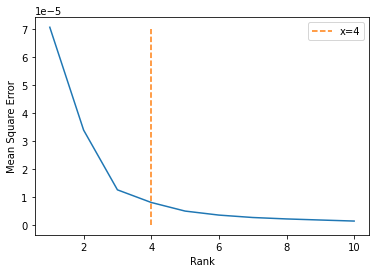

In [23]:
plt.plot(list(range(1,11)), county_errors)
plt.vlines(x=4, ymin=0, ymax= .00007, color="tab:orange", linestyle='dashed', label="x=4")
plt.xlabel("Rank")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()

### Plot the Map

In [41]:
clus = nmf_cluster(county_norm.dataframe, 4, clusters=None, cluster_method='kmeans', num_outliers=None)

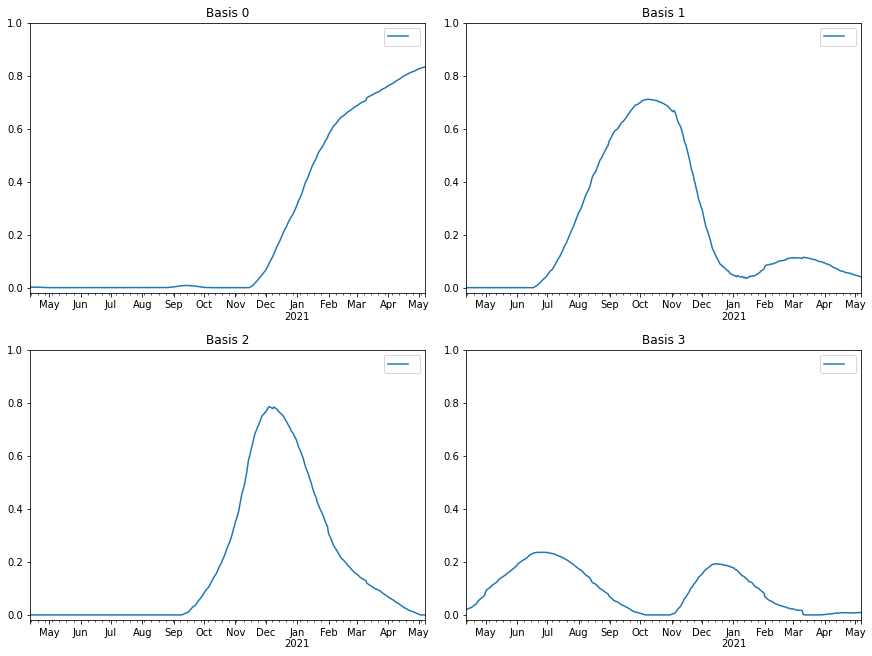

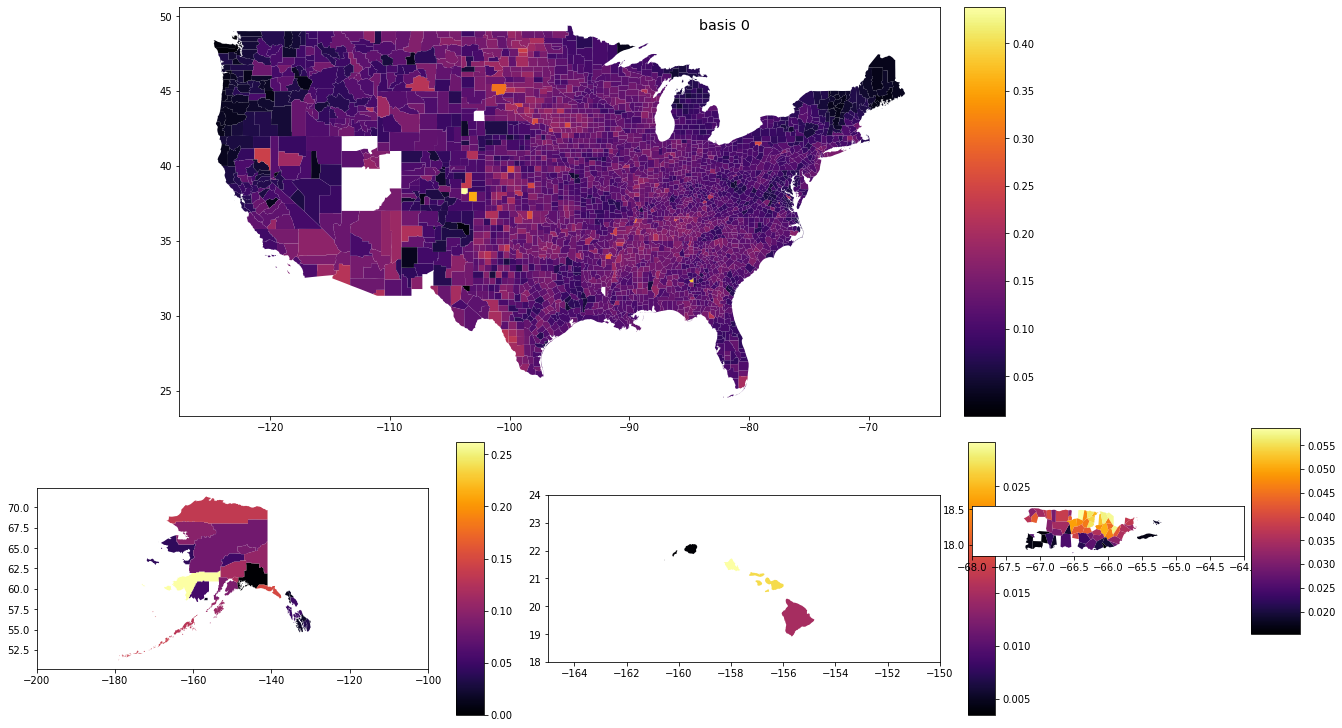

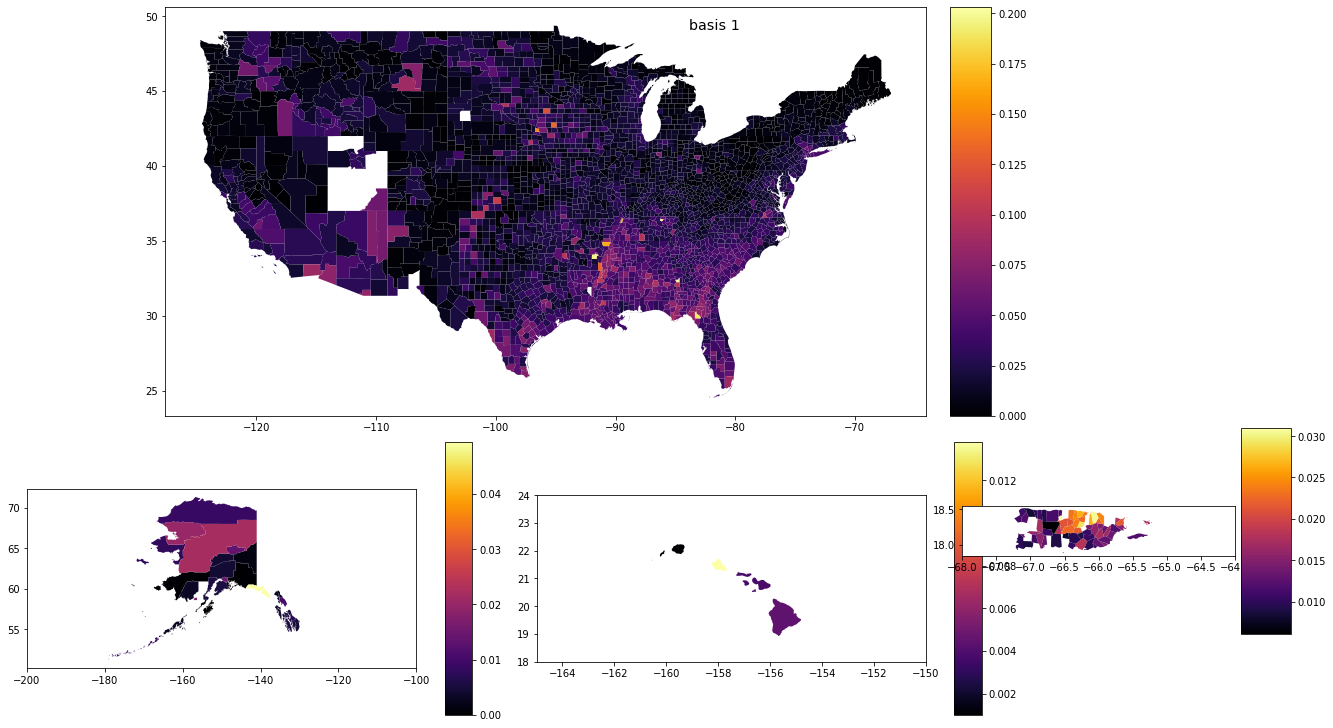

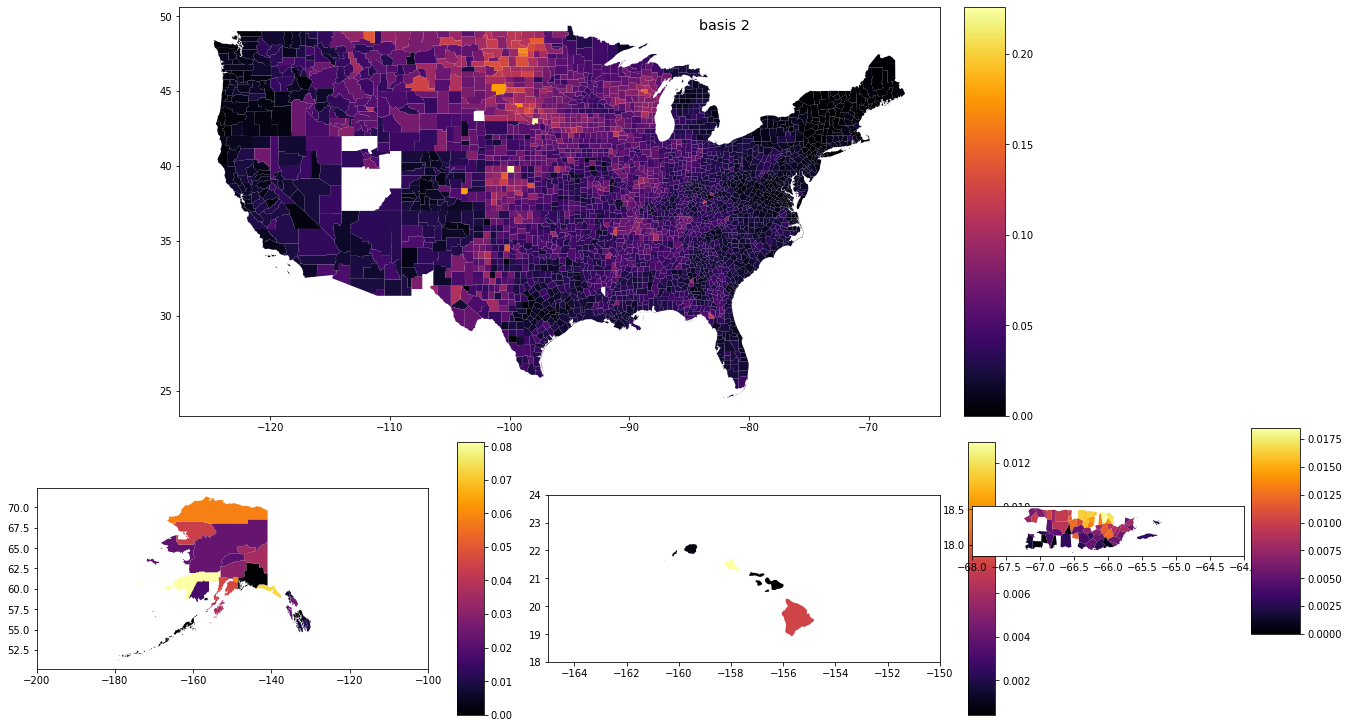

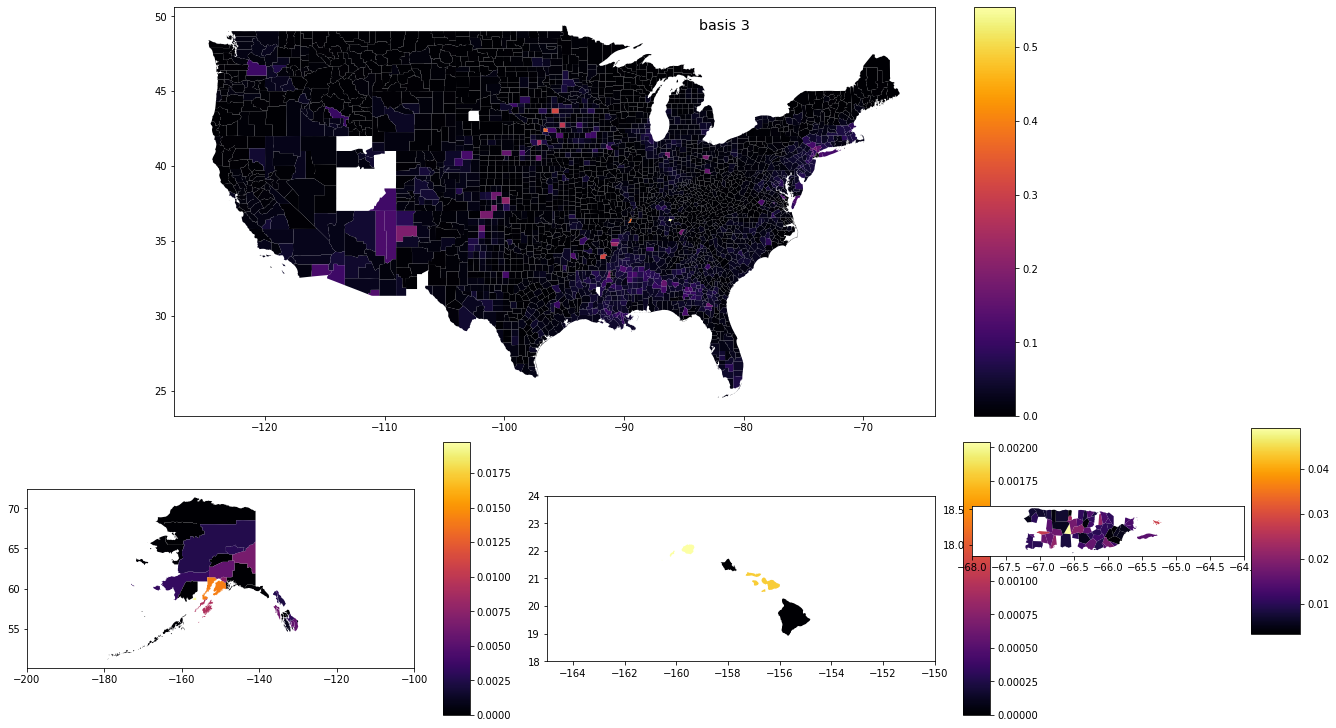

In [42]:
clus.basis_vectors()
clus.county_map_basis()

### Using/comparing to state bases

In [21]:
population = pd.read_csv(os.path.join(par, 'collected_data/census_estimate.csv'), index_col = 'NAME')
state_iso = state_dset.known_iso()

pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [22]:
state_nmf = nmf_cluster(state_norm.dataframe, 4, clusters=None, cluster_method='kmeans', num_outliers=None)

In [23]:
state_x = pd.DataFrame(state_nmf.X)
state_x.index = pd.to_datetime(state_norm.dataframe.index)

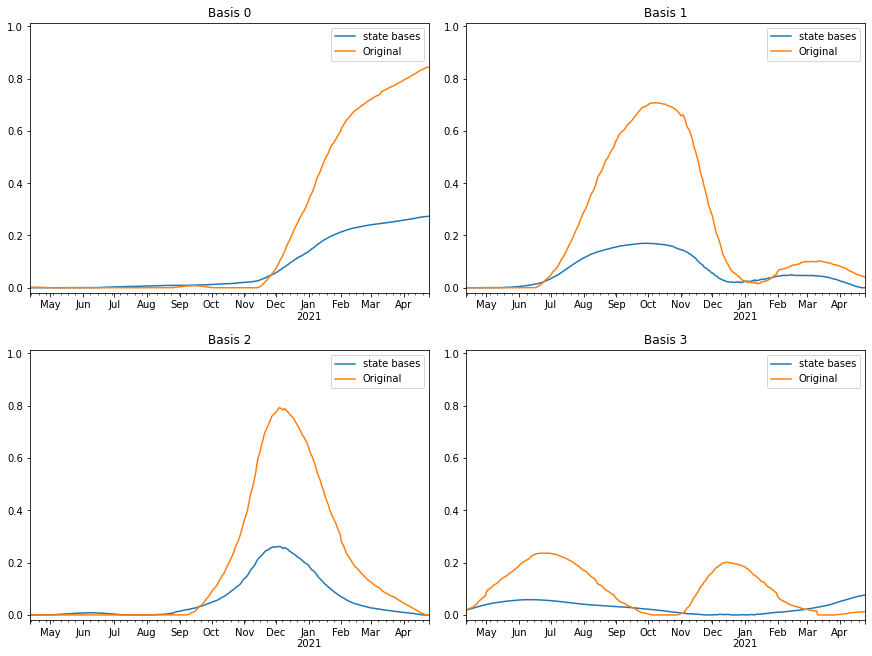

In [24]:
clus.basis_vectors(state_x, label = 'state bases')

In [25]:
ys = nmf_cluster(county_norm.dataframe,4, clusters=None, cluster_method='kmeans', num_outliers=None, w_init = state_nmf.X, h_init = clus.Y)

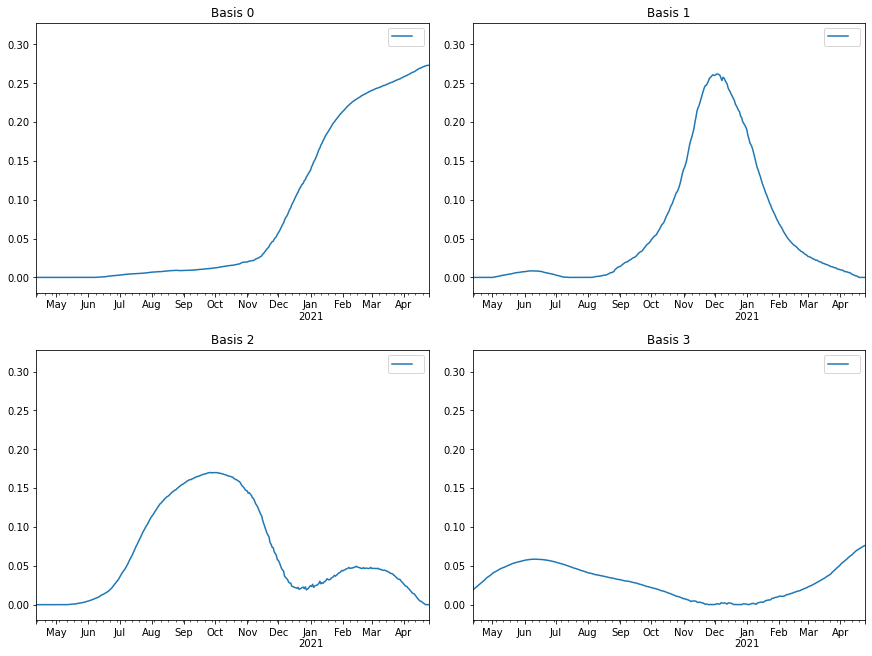

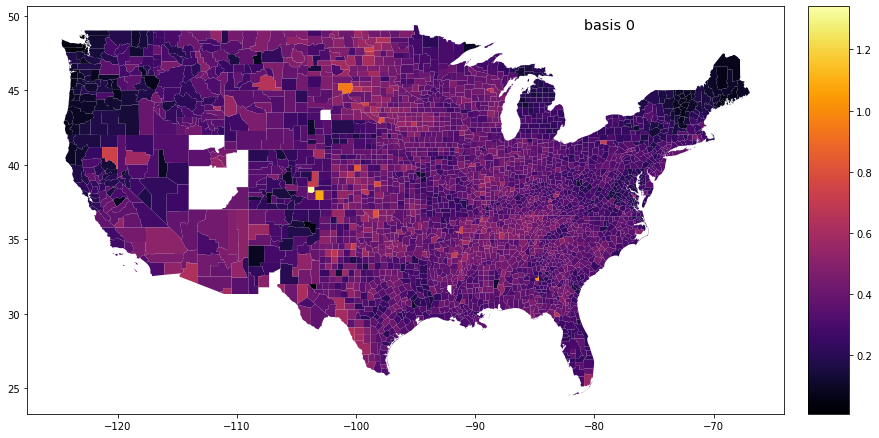

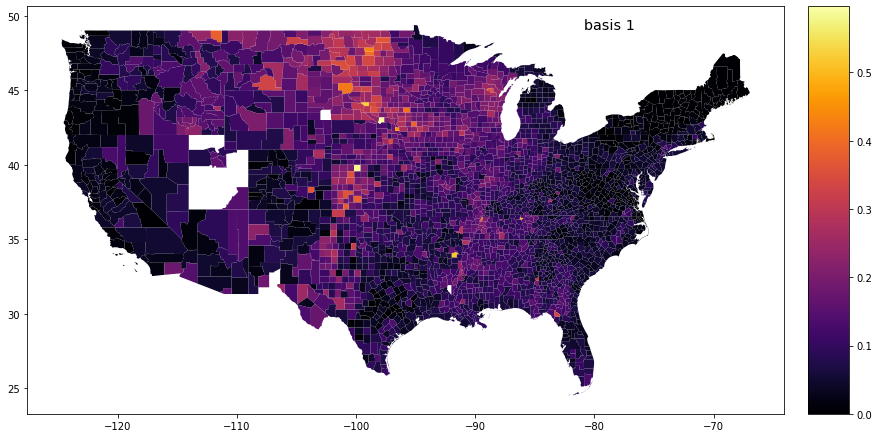

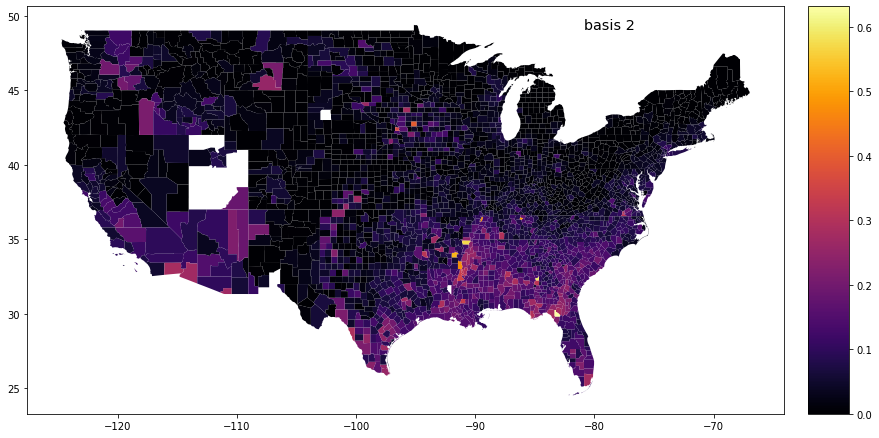

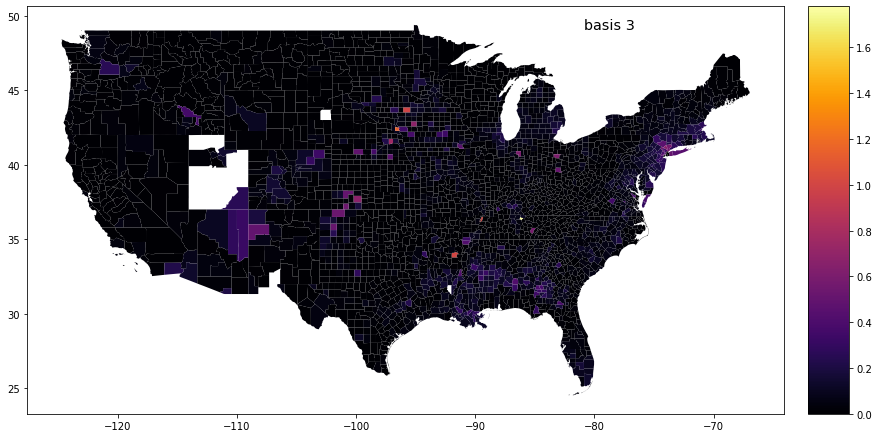

In [26]:
ys.basis_vectors()
ys.county_map_basis()

In [27]:
# error using state level bases
county_norm.mean_square_error(ys.nmf, 0)

9.502657112511558e-06

In [28]:
# error using NMF computed bases
county_norm.mean_square_error(clus.nmf, 0)

7.698024903930412e-06